In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader, hetero_graph_loader_faz
from utils import prep
import numpy as np
import json
import pandas as pd
from evaluation import evaluation
import copy

from itertools import product

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle


In [2]:
# print the current path
!pwd
# change the current path
%cd ..

/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/notebooks
/home/laurin/Documents/OCTA_project/repo/OCTA_gnn


/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 2, "Early NPDR": 1, "Late NPDR": 1}
#octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 3, "Early NPDR": 1, "Late NPDR": 2}
label_names = ["Healthy/DM", "NPDR", "PDR"]
#label_names = ["Healthy/DM", "Early NPDR","Late NPDR", "PDR"]

data_type = "DCP"

vessel_graph_path = f"../data/{data_type}_vessel_graph"
label_file = "../data/labels.csv"
void_graph_path = f"../data/{data_type}_void_graph"
hetero_edges_path = f"../data/{data_type}_heter_edges"





label_file = "../data/splits"

mode_cv = "cv"
cv_pickle = f"../data/{data_type}_{mode_cv}_dataset.pkl"
cv_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_cv,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = cv_pickle
                                                        )


mode_final_test = "final_test"
final_test_pickle = f"../data/{data_type}_{mode_final_test}_dataset.pkl"
final_test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_final_test,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = final_test_pickle
                                                        )


#octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 3, "Early NPDR": 1, "Late NPDR": 2}

#label_names = ["Healthy/DM", "Early NPDR", "Late NPDR", "PDR"]
# update the label dict

#final_test_dataset.update_class(octa_dr_dict)
#cv_dataset.update_class(octa_dr_dict)


"""

void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph_faz_node"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges_faz_node"

faz_node_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_faz_nodes"
faz_region_edge_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_faz_region_edges"
faz_vessel_edge_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_faz_vessel_edges"


mode_cv = "cv"
cv_pickle = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_{mode_cv}_dataset_faz.pkl"
cv_dataset = hetero_graph_loader_faz.HeteroGraphLoaderTorch(graph_path_1=vessel_graph_path,
                                                        graph_path_2=void_graph_path,
                                                        graph_path_3=faz_node_path,
                                                        hetero_edges_path_12=hetero_edges_path,
                                                        hetero_edges_path_13=faz_vessel_edge_path,
                                                        hetero_edges_path_23=faz_region_edge_path,
                                                        mode = mode_cv,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = cv_pickle #f"../{data_type}_{mode_train}_dataset_faz.pkl" # f"../{data_type}_{mode_train}_dataset_faz.pkl"
                                                        )


mode_final_test = "final_test"
final_test_pickle = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_{mode_final_test}_dataset_faz.pkl"
final_test_dataset = hetero_graph_loader_faz.HeteroGraphLoaderTorch(graph_path_1=vessel_graph_path,
                                                        graph_path_2=void_graph_path,
                                                        graph_path_3=faz_node_path,
                                                        hetero_edges_path_12=hetero_edges_path,
                                                        hetero_edges_path_13=faz_vessel_edge_path,
                                                        hetero_edges_path_23=faz_region_edge_path,
                                                        mode = mode_final_test,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = final_test_pickle #f"../{data_type}_{mode_train}_dataset_faz.pkl" # f"../{data_type}_{mode_train}_dataset_faz.pkl"
                                                        )
"""

num_classes = len(np.unique(list(octa_dr_dict.values())))

In [28]:

def aggreate_graph(dataset, features_label_dict, faz = False):
    # check if the datasets have an faz node type
    node_types = ["graph_1", "graph_2"]
    #try:
    #    dataset[0]["faz"]
    #    node_types.append("faz")
    #    x_1_shape = len(features_label_dict["graph_2"]) *2 + len(features_label_dict["graph_1"])
    #except KeyError:
    #    x_1_shape = len(features_label_dict["graph_2"]) + len(features_label_dict["graph_1"])

    if faz:
        node_types.append("faz")
        x_1_shape = len(features_label_dict["graph_2"]) *2 + len(features_label_dict["graph_1"])
    else:
        x_1_shape = len(features_label_dict["graph_2"]) + len(features_label_dict["graph_1"])

    x_0_shape = len(dataset)
    x = np.zeros((x_0_shape, x_1_shape))
    y = np.zeros((x_0_shape,))

    #x = np.zeros((len(dataset), len(features_label_dict["graph_1"])+len(features_label_dict["graph_2"])))
    #y = np.zeros((len(dataset),))

    for i in range(len(dataset)):
        graph_1 = dataset[i]["graph_1"]
        graph_2 = dataset[i]["graph_2"]
        y[i] = dataset[i].y
        
        # average the features of all nodes in the graph 
        graph_1_sum = graph_1.x.numpy().sum(axis = 0)
        graph_2_sum = graph_2.x.numpy().sum(axis = 0)

        graph_1_mean = graph_1.x.numpy().mean(axis = 0)
        graph_2_mean = graph_2.x.numpy().mean(axis = 0)

        graph_1_max = graph_1.x.numpy().max(axis = 0)
        graph_2_max = graph_2.x.numpy().max(axis = 0)

        graph_1_min = graph_1.x.numpy().min(axis = 0)
        graph_2_min = graph_2.x.numpy().min(axis = 0)

        graph_1_std = graph_1.x.numpy().std(axis = 0)
        graph_2_std = graph_2.x.numpy().std(axis = 0)

        # add averages to the matrix

        # add all features to the matrix
        #x[i,:len(features_label_dict["graph_1"])] = graph_1_sum
        #x[i,len(features_label_dict["graph_1"]):2*len(features_label_dict["graph_1"])] = graph_1_mean
        #x[i,2*len(features_label_dict["graph_1"]):3*len(features_label_dict["graph_1"])] = graph_1_max
        #x[i,3*len(features_label_dict["graph_1"]):4*len(features_label_dict["graph_1"])] = graph_1_min
        #x[i,4*len(features_label_dict["graph_1"]):5*len(features_label_dict["graph_1"])] = graph_1_std
#
        #x[i,5*len(features_label_dict["graph_1"]):5*len(features_label_dict["graph_1"])+len(features_label_dict["graph_2"])] = graph_2_sum
        #x[i,5*len(features_label_dict["graph_1"])+len(features_label_dict["graph_2"]):5*len(features_label_dict["graph_1"])+2*len(features_label_dict["graph_2"])] = graph_2_mean
        #x[i,5*len(features_label_dict["graph_1"])+2*len(features_label_dict["graph_2"]):5*len(features_label_dict["graph_1"])+3*len(features_label_dict["graph_2"])] = graph_2_max
        #x[i,5*len(features_label_dict["graph_1"])+3*len(features_label_dict["graph_2"]):5*len(features_label_dict["graph_1"])+4*len(features_label_dict["graph_2"])] = graph_2_min
        #x[i,5*len(features_label_dict["graph_1"])+4*len(features_label_dict["graph_2"]):5*len(features_label_dict["graph_1"])+5*len(features_label_dict["graph_2"])] = graph_2_std
        

        x[i,:len(features_label_dict["graph_1"])] = graph_1_sum
        x[i,len(features_label_dict["graph_1"]):] = graph_2_sum

        if "faz" in node_types:
            print("FAZ is in the node types")
            faz = dataset[i]["faz"]
            faz_sum = faz.x.numpy().sum(axis = 0)
            x[i,len(features_label_dict["graph_1"])+len(features_label_dict["graph_2"]):] = faz_sum

    return x, y


def hyper_param_search(grid, classifier, x_train, y_train, x_val, y_val):
    best_score = 0
    best_params = None
    for param_set in product(*grid.values()):
        params = dict(zip(grid.keys(), param_set))
        clf = classifier(**params, random_state=42)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        score = balanced_accuracy_score(y_val, y_pred)
        #score = cohen_kappa_score(y_val, y_pred, weights="quadratic") 
        if score > best_score:
            best_score = score
            best_params = params
            best_clf = clf

    y_pred = best_clf.predict(x_val)

    final_accuracy = accuracy_score(y_val, y_pred)
    final_balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    final_kappa = cohen_kappa_score(y_val, y_pred, weights="quadratic") # , weights="quadratic"

    print(f"Validation Accuracy: {final_accuracy}")
    print(f"Validation Balanced Accuracy: {final_balanced_accuracy}")
    print(f"Validation Kappa: {final_kappa}")
    # return the best classifier
    return best_params, best_score, best_clf

In [29]:
def evaluation_pipeline(model, x, y, label_names, title = None):
    y_pred = model.predict(x)
    y_prob = model.predict_proba(x)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    evaluation.plot_confusion_matrix(y, y_pred, label_names, ax[0]) #, ["Healthy/DM","PDR", "NPDR"]"Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])

    label_binarizer = LabelBinarizer().fit(y)
    y_onehot = label_binarizer.transform(y)


    if num_classes == 2:
        RocCurveDisplay.from_predictions(
            y,
            y_prob[:, 1],
            name="ROC curve",
            ax=ax[1],
            color="red",
        )
    else:
        for class_id, color in zip(range(num_classes), colors):
            RocCurveDisplay.from_predictions(
                y_onehot[:, class_id],
                y_prob[:, class_id],
                name=f"{class_id} vs the rest",
                color=color,
                ax=ax[1],
                plot_chance_level=(class_id == 2),
            )
    # add title
    if title is not None:
        fig.suptitle(title)
    plt.show()



    if num_classes == 2:
        mean_auc = roc_auc_score(
            y_true=y,
            y_score = y_prob[:,1],
            multi_class="ovo",
            average="macro",
        )
    else:
        mean_auc = roc_auc_score(
            y_true=y,
            y_score = y_prob,
            multi_class="ovo",
            average="macro",
        )

    # print metrics
    print(classification_report(y, y_pred, target_names=label_names))

    print(f"Accuracy Score: {accuracy_score(y, y_pred)}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y, y_pred)}")
    print(f"Mean AUC: {mean_auc}")
    print(f"Cohen Kappa Score (quadratic weights): {cohen_kappa_score(y, y_pred, weights='quadratic')}")



In [30]:

def eliminiate_features(train_dataset, test_dataset, val_dataset):
    # read the feature_name_dict.json
    import torch
    with open("feature_name_dict.json", "r") as file:
        label_dict_full = json.load(file)
        #features_label_dict = json.load(file)
    features_label_dict = copy.deepcopy(label_dict_full)

    eliminate_features = {"graph_1":["hasNodeAtSampleBorder", "maxRadiusStd", "avgRadiusStd", "hetero_degree"], 
                          "graph_2":["centroid_weighted-0", "centroid_weighted-1","orientation","solidity", "intensity_max", "intensity_mean", "intensity_min"]} # "feret_diameter_max", "equivalent_diameter",  #"centroid_weighted-0", "centroid_weighted-1", 
#
    for key in eliminate_features.keys():
        for feat in eliminate_features[key]:
            idx = features_label_dict[key].index(feat)
            features_label_dict[key].remove(feat)
            for data in train_dataset:
                data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)
            for data in test_dataset:
                data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)
            for data in val_dataset:
                data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)



    return train_dataset, test_dataset, val_dataset, features_label_dict

Split 1
845
211
211
Validation Accuracy: 0.7440758293838863
Validation Balanced Accuracy: 0.635545640453616
Validation Kappa: 0.6269888037713612


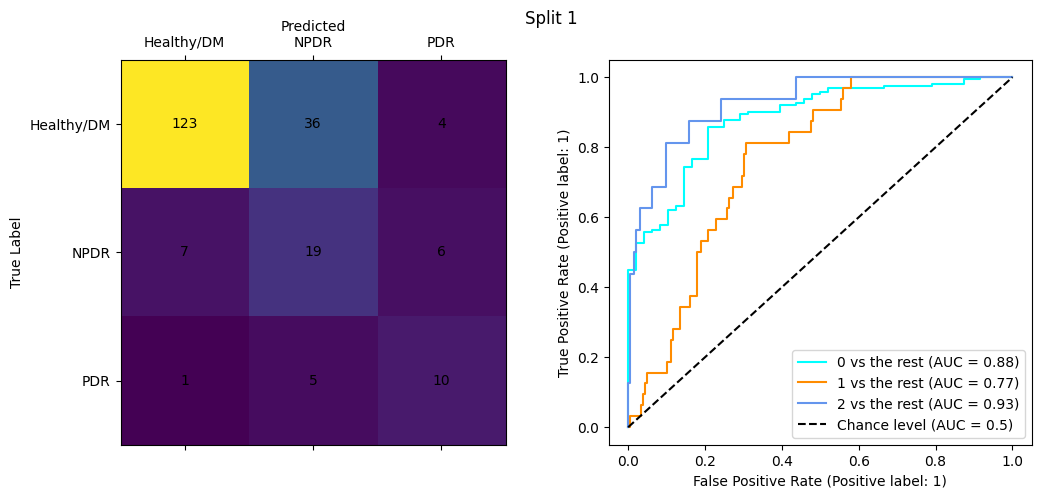

              precision    recall  f1-score   support

  Healthy/DM       0.94      0.75      0.84       163
        NPDR       0.32      0.59      0.41        32
         PDR       0.50      0.62      0.56        16

    accuracy                           0.72       211
   macro avg       0.59      0.66      0.60       211
weighted avg       0.81      0.72      0.75       211

Accuracy Score: 0.7203791469194313
Balanced Accuracy Score: 0.6577837423312883
Mean AUC: 0.8263056780419223
Cohen Kappa Score (quadratic weights): 0.5779543734457779
Split 2
845
211
211
Validation Accuracy: 0.7914691943127962
Validation Balanced Accuracy: 0.686221881390593
Validation Kappa: 0.7339360931505379


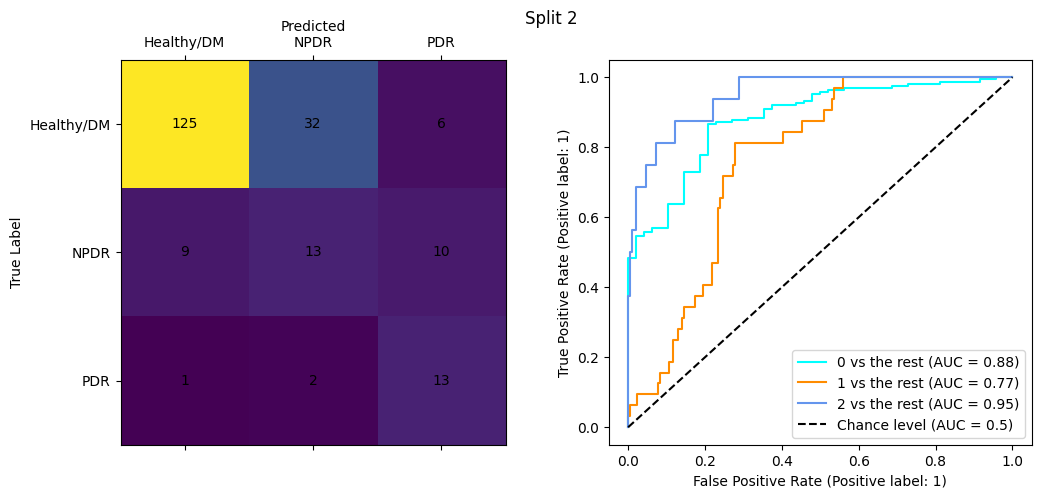

              precision    recall  f1-score   support

  Healthy/DM       0.93      0.77      0.84       163
        NPDR       0.28      0.41      0.33        32
         PDR       0.45      0.81      0.58        16

    accuracy                           0.72       211
   macro avg       0.55      0.66      0.58       211
weighted avg       0.79      0.72      0.74       211

Accuracy Score: 0.7156398104265402
Balanced Accuracy Score: 0.6618737218813906
Mean AUC: 0.8440715267126789
Cohen Kappa Score (quadratic weights): 0.5852605013467932
Split 3
844
212
211
Validation Accuracy: 0.7830188679245284
Validation Balanced Accuracy: 0.6845651638334566
Validation Kappa: 0.642684644797746


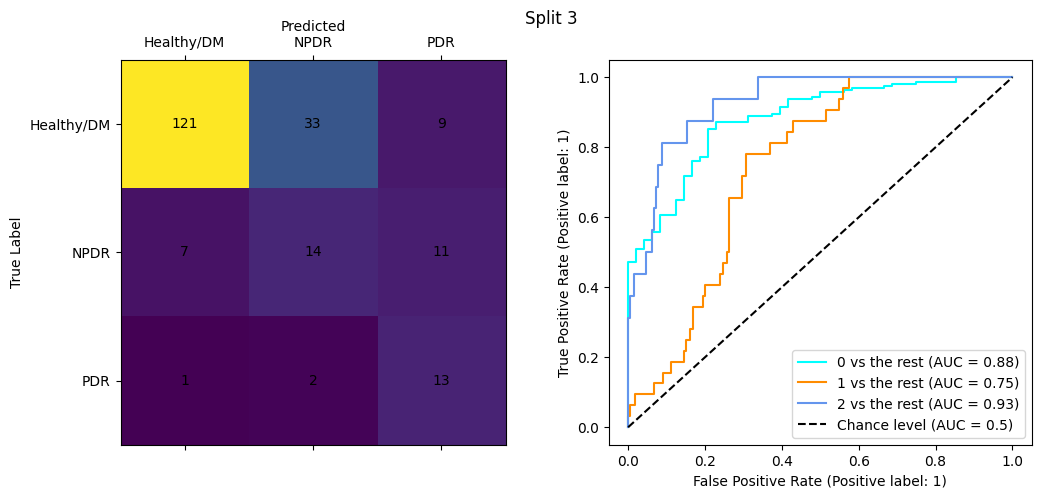

              precision    recall  f1-score   support

  Healthy/DM       0.94      0.74      0.83       163
        NPDR       0.29      0.44      0.35        32
         PDR       0.39      0.81      0.53        16

    accuracy                           0.70       211
   macro avg       0.54      0.66      0.57       211
weighted avg       0.80      0.70      0.73       211

Accuracy Score: 0.7014218009478673
Balanced Accuracy Score: 0.6641104294478528
Mean AUC: 0.8145270162321063
Cohen Kappa Score (quadratic weights): 0.5512383653120498
Split 4
844
212
211
Validation Accuracy: 0.8018867924528302
Validation Balanced Accuracy: 0.6968402903083524
Validation Kappa: 0.7177723541158199


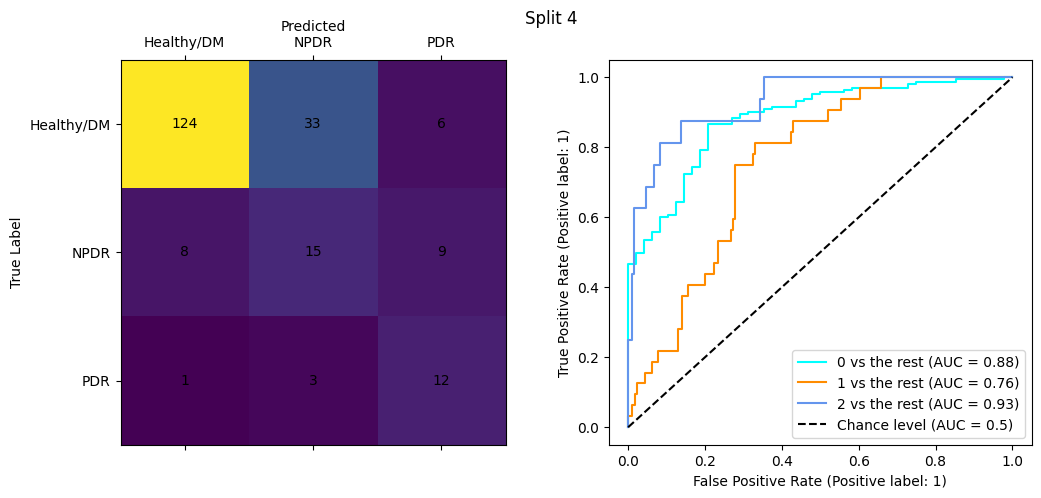

              precision    recall  f1-score   support

  Healthy/DM       0.93      0.76      0.84       163
        NPDR       0.29      0.47      0.36        32
         PDR       0.44      0.75      0.56        16

    accuracy                           0.72       211
   macro avg       0.56      0.66      0.59       211
weighted avg       0.80      0.72      0.74       211

Accuracy Score: 0.7156398104265402
Balanced Accuracy Score: 0.6598287321063395
Mean AUC: 0.82920141551636
Cohen Kappa Score (quadratic weights): 0.5765886287625419
Split 5
846
210
211
Validation Accuracy: 0.7428571428571429
Validation Balanced Accuracy: 0.6463658827539196
Validation Kappa: 0.6089790007241129


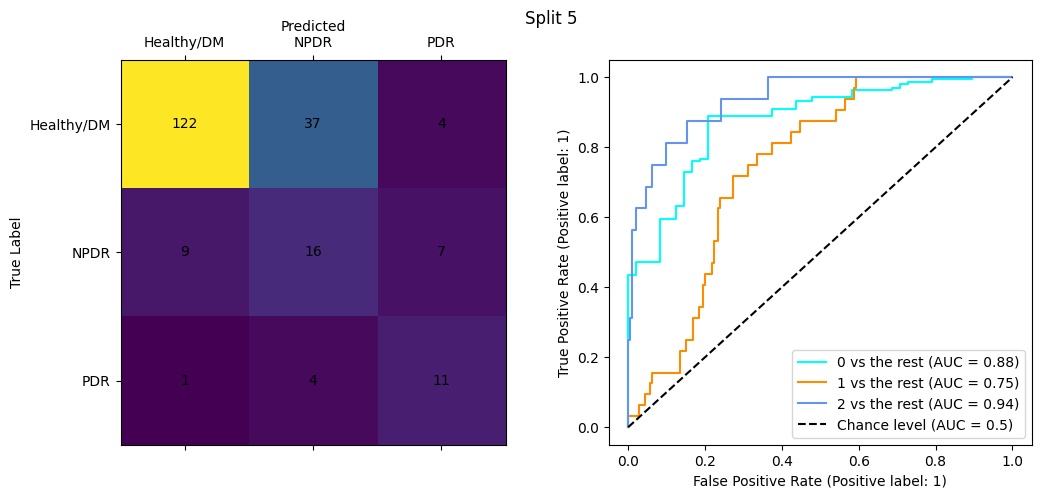

              precision    recall  f1-score   support

  Healthy/DM       0.92      0.75      0.83       163
        NPDR       0.28      0.50      0.36        32
         PDR       0.50      0.69      0.58        16

    accuracy                           0.71       211
   macro avg       0.57      0.65      0.59       211
weighted avg       0.79      0.71      0.74       211

Accuracy Score: 0.7061611374407583
Balanced Accuracy Score: 0.6453220858895706
Mean AUC: 0.8259442101226994
Cohen Kappa Score (quadratic weights): 0.5715792526962529


In [32]:
param_grid = {'max_depth': [4, 5, 6, 8], 'max_features': ["sqrt", "log2"], 'class_weight': ['balanced','balanced_subsample', None], 'n_estimators': [100,  300]} 
classifier = RandomForestClassifier

#param_grid = {'C' : [0.1, 1], 'gamma' : [0.1, 1], 'kernel' : ["rbf", "linear"] , 'probability' : [True], 'class_weight': ['balanced', None]} #SVC #, "poly", "sigmoid"
#classifier = SVC

with open("feature_name_dict.json", "r") as file:
    label_dict_full = json.load(file)
    #features_label_dict = json.load(file)
features_label_dict = copy.deepcopy(label_dict_full)


best_param_dict = {}
best_score_dict = {}
clf_dict = {}

for split in [1,2,3,4,5]:
    print(f"Split {split}")

    train_dataset, val_dataset, test_dataset = prep.adjust_data_for_split(cv_dataset, final_test_dataset, split)

    #train_dataset, test_dataset, val_dataset, features_label_dict = eliminiate_features(train_dataset, test_dataset, val_dataset)

    train_dataset_work = copy.deepcopy(train_dataset.hetero_graph_list)
    val_dataset_work = copy.deepcopy(val_dataset.hetero_graph_list)
    test_dataset_work = copy.deepcopy(test_dataset.hetero_graph_list)

    x_train, y_train = aggreate_graph(train_dataset_work, features_label_dict)
    x_val, y_val = aggreate_graph(val_dataset_work, features_label_dict)
    x_test, y_test = aggreate_graph(test_dataset_work, features_label_dict)

    best_params, best_score, clf = hyper_param_search(param_grid, classifier, x_train, y_train, x_val, y_val)
    best_param_dict[split] = best_params
    best_score_dict[split] = best_score
    clf_dict[split] = clf



    evaluation_pipeline(clf, x_test, y_test, label_names, title = f"Split {split}")


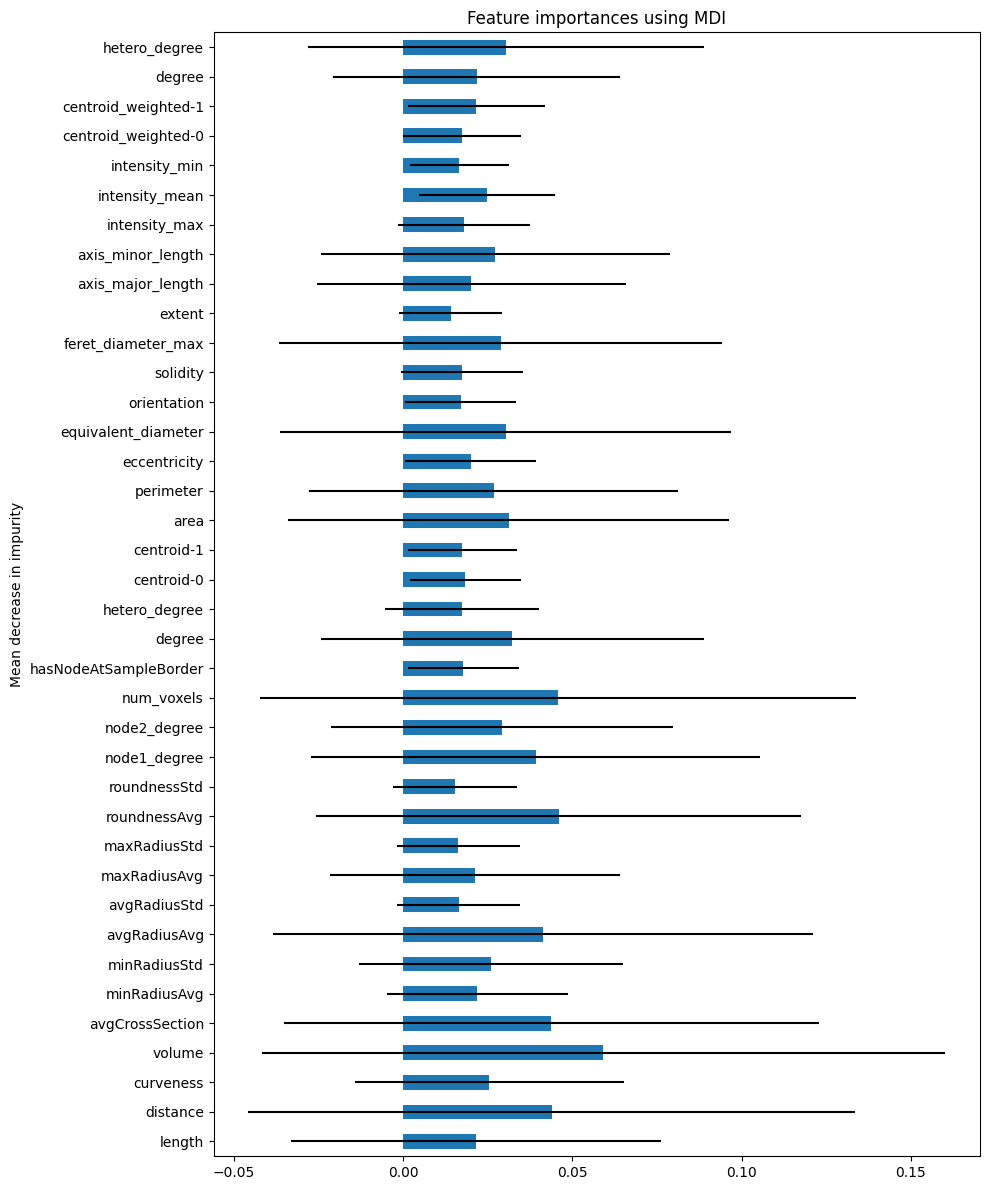

In [9]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots(figsize=(10, 12))

forest_importances.plot.barh(xerr=std, ax=ax)
# add feature names as x-axis labels, avoid overwriting
feature_names = features_label_dict["graph_1"] + features_label_dict["graph_2"] #+ features_label_dict["graph_2"] + ["y_label"]
ax.set_yticklabels(feature_names) # , rotation=90
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# last features are the segmentation features

In [10]:
# print the best parameters
for split in best_param_dict.keys():
    print(f"Split {split}")
    print(best_param_dict[split])
    print(best_score_dict[split])



"""Split 1
{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
0.6017723244717109
Split 2
{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
0.5065184049079755
Split 3
{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
0.5149790588814979
Split 4
{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
0.5534905168611411
Split 5
{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
0.6074812542603953"""

Split 1
{'max_depth': 8, 'max_features': 'log2', 'class_weight': 'balanced', 'n_estimators': 100}
0.6525459300636078
Split 2
{'max_depth': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'n_estimators': 300}
0.7339360931505379
Split 3
{'max_depth': 5, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'n_estimators': 100}
0.6489157998240438
Split 4
{'max_depth': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'n_estimators': 100}
0.721689497716895
Split 5
{'max_depth': 8, 'max_features': 'log2', 'class_weight': 'balanced', 'n_estimators': 300}
0.6655641308342521


"Split 1\n{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}\n0.6017723244717109\nSplit 2\n{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}\n0.5065184049079755\nSplit 3\n{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}\n0.5149790588814979\nSplit 4\n{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}\n0.5534905168611411\nSplit 5\n{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}\n0.6074812542603953"

In [10]:
# with each classifier stored in clf_dict, predict the final test set

df_report = pd.DataFrame()
df_metrics = pd.DataFrame()
df_best_params = pd.DataFrame()

for clf_name, clf in clf_dict.items():
    y_pred = clf.predict(x_test)
    y_prob = clf.predict_proba(x_test)
    if num_classes == 2:
        mean_auc = roc_auc_score(
            y_true=y_test,
            y_score = y_prob[:,1],
            multi_class="ovo",
            average="macro",
        )
    else:
        mean_auc = roc_auc_score(
            y_true=y_test,
            y_score = y_prob,
            multi_class="ovo",
            average="macro",
        )
    report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)

    acc= accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred, weights="quadratic")

    metrics = {}

    metrics["accuracy"] = acc
    metrics["balanced_accuracy"] = bal_acc
    metrics["kappa"] = kappa
    metrics["mean_auc"] = mean_auc

    df_metrics = pd.concat([df_metrics, pd.DataFrame(metrics, index = [clf_name])])

    df_report = pd.concat([df_report, pd.DataFrame(report).transpose()])
    df_best_params = pd.concat([df_best_params, pd.DataFrame(best_param_dict[clf_name], index = [clf_name])])


    #results_report[clf_name] = report

df_metrics.to_csv('RF_CV_metrics_3class_all_feat_mean.csv')
df_report.to_csv('RF_CV_report_3class_all_feat_mean.csv')
df_best_params.to_csv('RF_CV_best_params_3class_all_feat_mean.csv')




In [ ]:
# plot the correlations of the features with the y label

# concatenate the y_label to the y_train

y_train = y_train.reshape(-1,1)
x_train = np.concatenate((x_train, y_train), axis = 1)

# get the feature names
feature_names = features_label_dict["graph_1"] + features_label_dict["graph_2"] + features_label_dict["graph_2"] + ["y_label"]

# compute corrcealtion matrix
corr_matrix = np.corrcoef(x_train, rowvar = False)
# print the correlations with the y label
print(corr_matrix[-1,:-1])


NameError: name 'y_train' is not defined

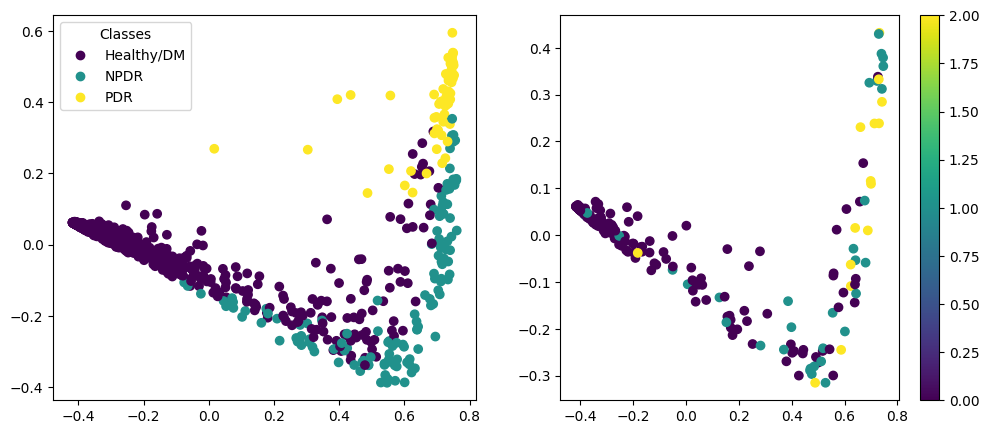

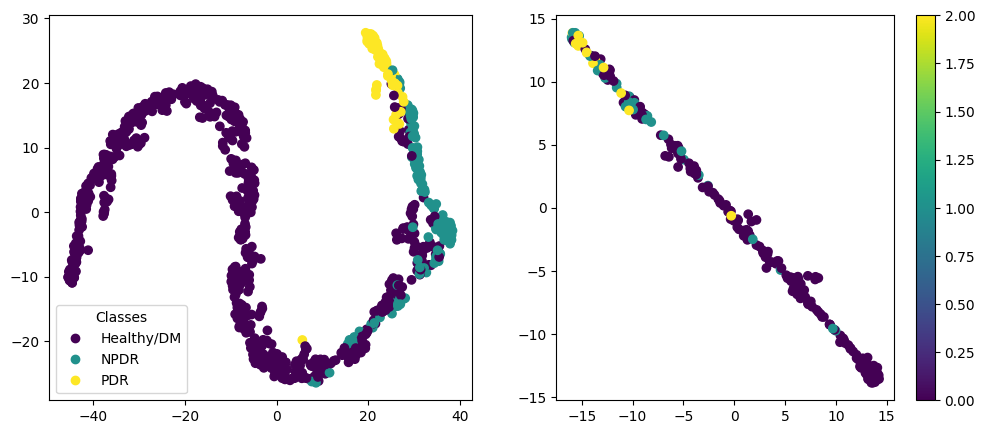

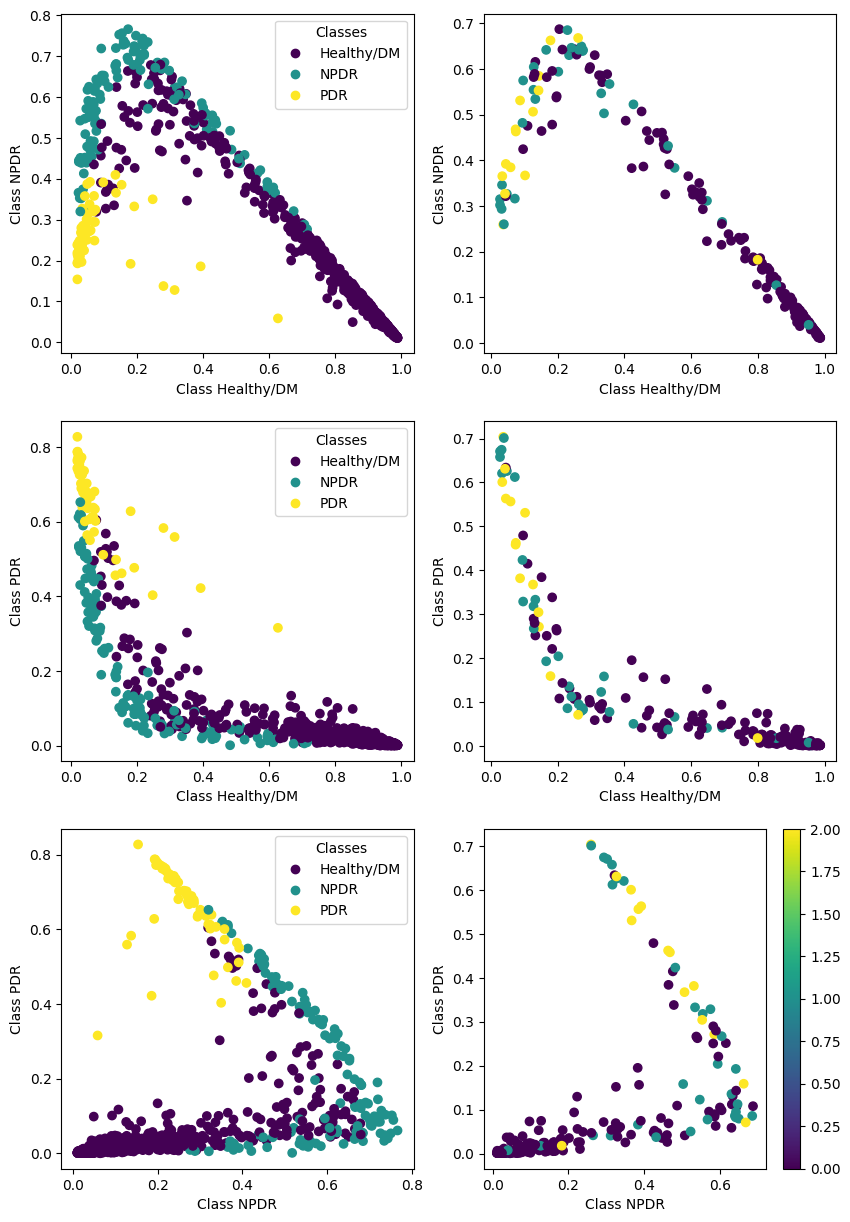

In [ ]:
# tsne embedding for visualization
y_prob_train = rf_best.predict_proba(x_train)
y_prob_test = rf_best.predict_proba(x_test)

evaluation.pca_transform_plot(y_prob_train, y_prob_test, y_train, y_test, label_names)
evaluation.tsne_transform_plot(y_prob_train, y_prob_test, y_train, y_test, label_names)
evaluation.embedding_plot(y_prob_train, y_prob_test, y_train, y_test, label_names)

In [ ]:


#faz_features = graph_2_featues.copy()
#for feature in faz_features:
#    faz_features[faz_features.index(feature)] = "faz_" + feature
#
#seg_features = ["global_mask_ratio", "top_left_ratio", "top_right_ratio", "bottom_left_ratio", "bottom_right_ratio"]

#feature_names = graph_1_features + graph_2_featues + global_node_features+ faz_features + seg_features
#print(len(feature_names))

In [ ]:
# feature name 

feature_names = features_label_dict["graph_1"] + features_label_dict["graph_2"]

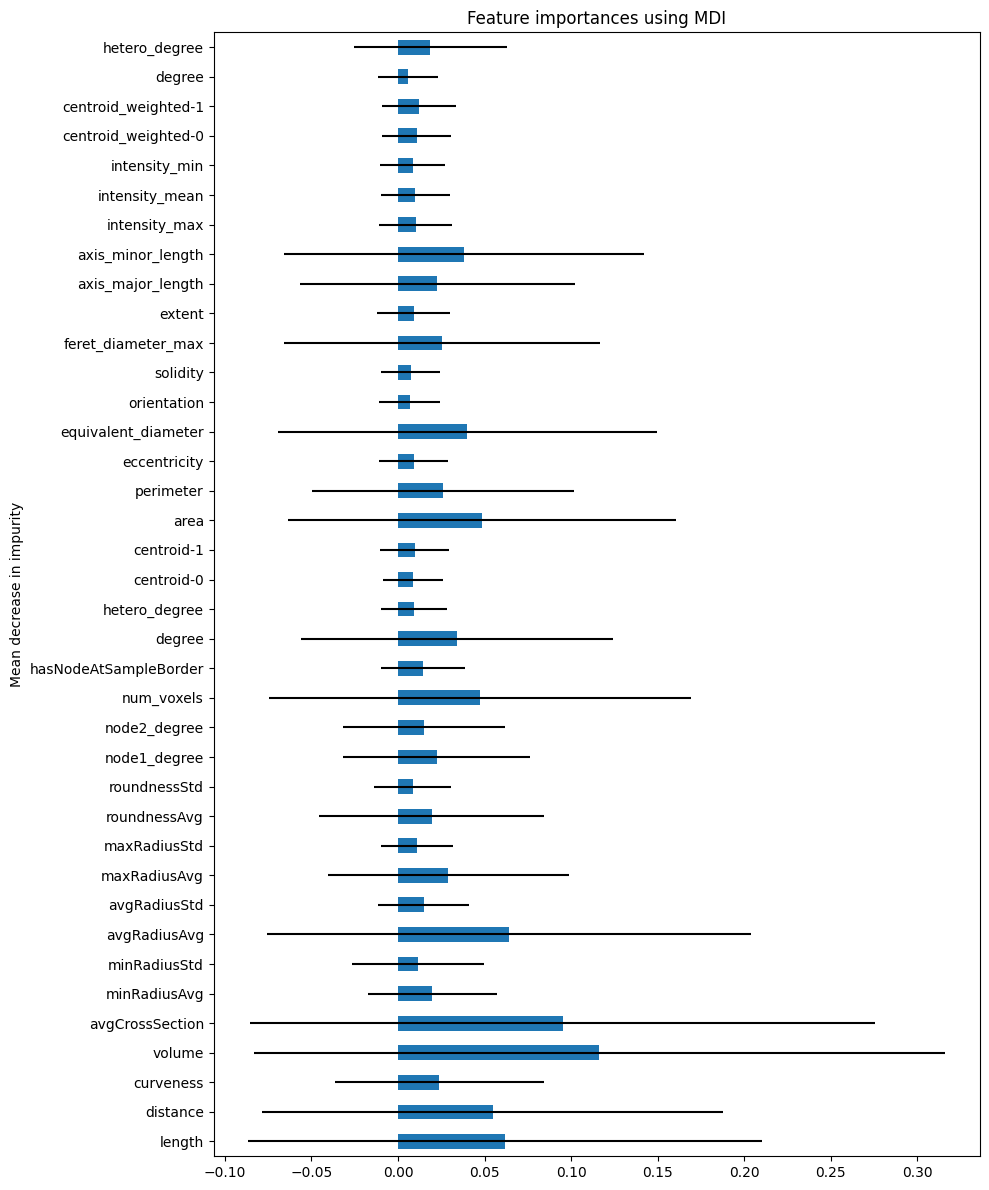

In [ ]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots(figsize=(10, 12))

forest_importances.plot.barh(xerr=std, ax=ax)
# add feature names as x-axis labels, avoid overwriting
ax.set_yticklabels(feature_names) # , rotation=90
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# last features are the segmentation features

In [ ]:
#param_grid = {'learning_rate' : [0.5, 0.1, 0.01], 'max_iter' : [100,200]}  #HistGradientBoostingClassifier

#param_grid = {'n_estimators': [100,  300]}  #AdaBoostClassifier

param_grid = {'C' : [0.1, 1], 'gamma' : [0.1, 1], 'kernel' : ["rbf", "linear"] , 'probability' : [True]} #SVC #, "poly", "sigmoid"

best_params = None
best_metric = 0

# Hyperparameter search loop
for param_set in product(*param_grid.values()):
    current_params = dict(zip(param_grid.keys(), param_set))

    # Train the model on the training set
    current_model = SVC(**current_params) 
    current_model.fit(x_train, y_train)

    # Evaluate on the validation set
    val_predictions = current_model.predict(x_test)
    val_prob_pred = current_model.predict_proba(x_test)
    current_accuracy = balanced_accuracy_score(y_test, val_predictions)
    if num_classes == 2:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred[:,1],
            multi_class="ovr",
            average="macro",
        )
    else:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred,
            multi_class="ovr",
            average="macro",
        )
    kappa = cohen_kappa_score(y_test, val_predictions, weights="quadratic") # , weights="quadratic"
    metric =  kappa

    # Update best parameters if current model is better
    if metric > best_metric:
        best_metric = metric
        best_params = current_params
        print(best_metric)


alt_cls_best = SVC(**best_params) # , class_weight='balanced'
_=alt_cls_best.fit(x_train, y_train)


0.6255987964685854
0.6884704073789393


In [ ]:
## visualize a single tree
#estimator = rf_best.estimators_[5]
#
#from sklearn.tree import export_graphviz
## Export as dot file
#export_graphviz(estimator, out_file='tree.dot',
#                feature_names = features_label_dict["graph_1"] + features_label_dict["graph_2"],
#                class_names = label_names,
#                rounded = True, proportion = False,
#                precision = 2, filled = True)
#
## Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
#
## Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')


In [ ]:

# do data imputation
#prep.hetero_graph_imputation(train_dataset)
#prep.hetero_graph_imputation(test_dataset)
#
#prep.add_node_features(train_dataset, ["graph_1", "graph_2"])
#prep.add_node_features(test_dataset, ["graph_1", "graph_2"])
#
## extract graph features
#train_g_extractor = graph_feature_extraction.GraphFeatureExtractor(train_dataset.hetero_graphs, mode=torch.mean)# 
#train_g_feature_dict = train_g_extractor.get_feature_dict()
#train_g_faz_feature_dict = train_g_extractor.get_faz_feature_dict()
#
#test_g_extractor = graph_feature_extraction.GraphFeatureExtractor(test_dataset.hetero_graphs, mode=torch.mean)# 
#test_g_feature_dict = test_g_extractor.get_feature_dict()
#test_g_faz_feature_dict = test_g_extractor.get_faz_feature_dict()
#
#prep.add_global_node(train_dataset)
#prep.add_global_node(test_dataset)

#train_dataset[0].x_dict["global"]



#octa_dr_dict_update = {"Healthy": 0, "DM": 0, "PDR": 2, "Early NPDR": 1, "Late NPDR": 1}
#train_dataset.update_class(octa_dr_dict_update)
#test_dataset.update_class(octa_dr_dict_update)
#
#num_classes = np.unique(list(octa_dr_dict_update.values())).shape[0]
#print(f"Number of classes: {num_classes}")



#extract segmentation features
#seg_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_seg"
#seg_extractor = seg_feature_extraction.SegFeatureExtractor(seg_path)
#seg_feature_dict = seg_extractor.get_feature_dict()


#train_comb_feature_dict = prep.create_combined_feature_dict(train_g_feature_dict,train_g_faz_feature_dict, seg_feature_dict, train_dataset)
#test_comb_feature_dict = prep.create_combined_feature_dict(test_g_feature_dict,test_g_faz_feature_dict, seg_feature_dict, test_dataset)




#x_train = np.array([val[0] for val in train_comb_feature_dict.values()])
#y_train = np.array([val[1] for val in train_comb_feature_dict.values()])
#
#x_test = np.array([val[0] for val in test_comb_feature_dict.values()])
#y_test = np.array([val[1] for val in test_comb_feature_dict.values()])
